In [2]:
%load_ext autoreload
%autoreload 2

# Self-Supervised Learning

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/learn/04_self_supervised_learning.ipynb)

As we saw in the previous notebook, using pre-trained convnets gives us better data efficiency. In our example we were able to go from a 15% error rate to a 5% error rate, which is a 66% improvement, by leveragin the pre-trained weights on the Imagenet dataset, which is very different from satellite imagery. The problem is that there is no imagenet-like dataset for satellite imagery, nor pre-trained models on this data types (which is a common problem in many real world applications). However, we have available large datasets of unlabeled satellite images, so our objective will be to pre-train a convnet on unlabeled data (closer to our problem) in a self-supervised way, and then use it to fine-tune a model on our labeled data to obtain even better results.

In this example we are going to pre-train a resnet18 on the [SeCo](https://github.com/ServiceNow/seasonal-contrast) 100k RGB variant dataset using the [Barlow Twins](https://arxiv.org/abs/2103.03230) framework.

In [3]:
from convnets.datasets import SeCo 

seco = SeCo()

In [4]:
seco.data

,image
0,/fastdata/seasonal_contrast_100k/004556/202007...
1,/fastdata/seasonal_contrast_100k/004556/201911...
2,/fastdata/seasonal_contrast_100k/004556/202004...
3,/fastdata/seasonal_contrast_100k/004556/202009...
4,/fastdata/seasonal_contrast_100k/004556/202001...
...,...
99995,/fastdata/seasonal_contrast_100k/013355/201907...
99996,/fastdata/seasonal_contrast_100k/013355/201909...
99997,/fastdata/seasonal_contrast_100k/013355/202005...
99998,/fastdata/seasonal_contrast_100k/013355/202003...


In [5]:
from convnets.datasets import SSLDataset 
import albumentations as A

dataset = SSLDataset(seco.data.image.values, trans=A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.5, 1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    A.GaussianBlur(p=0.3),
    # A.Solarize(p=0.3)
]))

len(dataset)

100000

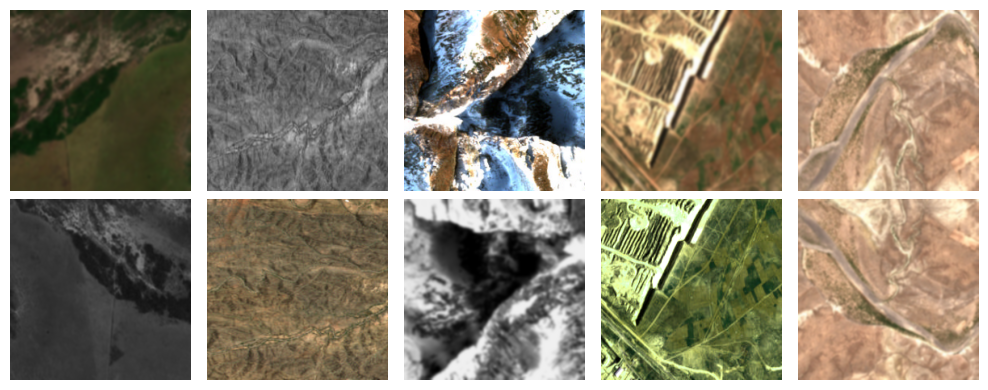

In [6]:
import random
import matplotlib.pyplot as plt
from einops import rearrange

r, c = 2, 5
plt.figure(figsize=(c*2, r*2))
for col in range(c):
    plt.subplot(r, c, col + 1)
    ix = random.randint(0, len(dataset)-1)
    im1, im2 = dataset[ix]
    plt.imshow(rearrange(im1, 'c h w -> h w c'))
    plt.axis('off')
    plt.subplot(r, c, c + col + 1)
    plt.imshow(rearrange(im2, 'c h w -> h w c'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
import torchvision
from convnets.models import BarlowTwins
import torch
from convnets.train import barlow_fit 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)

backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
model = BarlowTwins(backbone)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.03, max_lr=1e-3, total_steps=100, verbose=True)

# hist = barlow_fit(model, dataloader, optimizer, scheduler, epochs=100, limit_train_batches=100)

Adjusting learning rate of group 0 to 4.0000e-05.


After training (it will take a while) we can load the model and use it for fine-tuning on our labeled dataset. 

In [8]:
from convnets.datasets import EuroSAT
from convnets.datasets import ImageClassificationDataset 
from convnets.train import fit 
import pandas as pd
import torch
from torch.utils.data import DataLoader
from convnets.train import seed_everything

seed_everything()

data = EuroSAT()

dataset = {
    'train': ImageClassificationDataset(data.train.image.values, data.train.label.values),
    'val': ImageClassificationDataset(data.test.image.values, data.test.label.values),
}

dataloaders  =  {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

# load pre-trained model
model.load_state_dict(torch.load('./checkpoints/barlow.pth'))
ft_model = torch.nn.Sequential(
    model.backbone,
    torch.nn.Linear(512, data.num_classes),
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda:1', log=False, epochs=50)

df_ssl = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df_ssl.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df_ssl.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400


FileNotFoundError: [Errno 2] No such file or directory: 'barlow.pth'